# Introduction

**Neural style transfer** 

It is an optimization technique used to take two images, a content image and a style reference image and blend them together so the output image looks like the content image but painted in a style like style reference image 

**Objective**

There are four learning objectives for this model. Firstly load pretrained VGG-19 model then extract content and style features. After that create style and content loss function. In the end minimize the total loss to generate artistic style image.  

**VGG-19 Model**

VGG19 is a variant of VGG model which in short consists of 19 layers which include convolution layers, fully connected layer and max pool layers and softmax layer. there are other varinats of VGG like VGG11, VGG16 and other. 

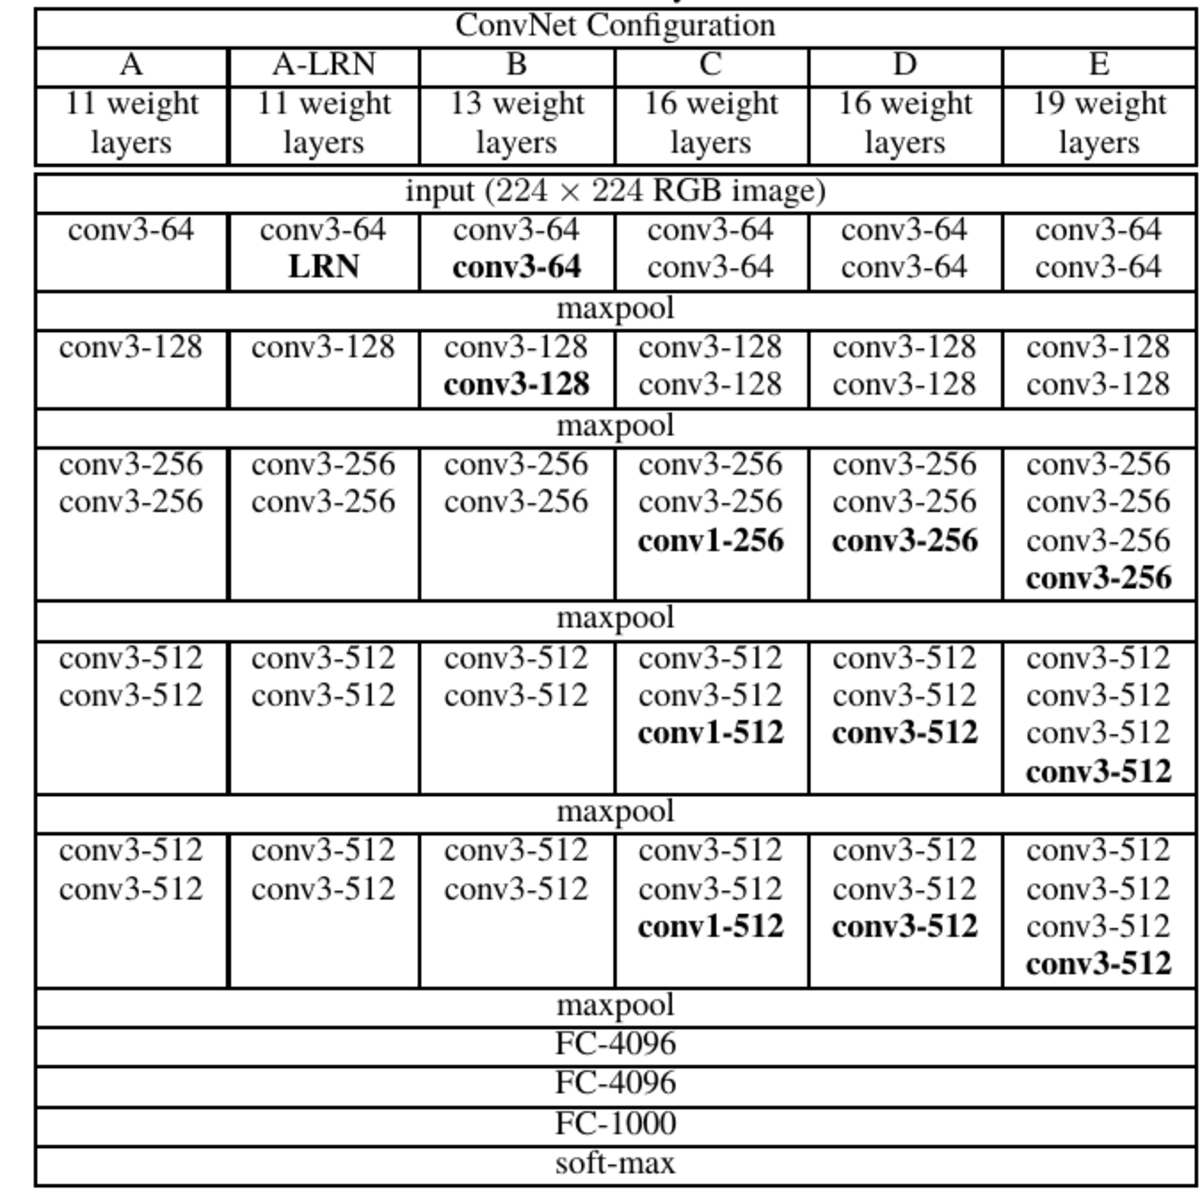



Steps for building Neural Style Transfer 
* Task 1: Set goodle colab runtime 
* Task 2: Loading VGG-19 pretrained model 
* Task 3: Preprocess Image 
* Task 4: Deprocess Image
* Task 5: Create Content and style loss 
* Task 6: Get content, style features and create gram matrix 
* Task 7: Training Loop 





In [1]:
!nvidia-smi

Sat Aug 21 22:47:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install torch torchvision 

In [3]:
!git clone https://github.com/parth1620/Project-NST.git

Cloning into 'Project-NST'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [4]:
# Loading VGG Pretrained Model 
""" 
PyTorch is an open-source machine learning library based on the
Torch library, used for applications such as computer vision 
and natural language processing. Primarily developed by Facebook's
AI Research Lab.

"""
import torch 
from torchvision import models 

"""
The models subpackage contains definitions of models for addressing 
different tasks, including: image classification, pixelwise semantic 
segmentation, object detection, instance segmentation, person keypoint 
detection and video classification.

"""

vgg = models.vgg19(pretrained = True)
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
# We will just use the feature part of VGG19 so we will remove the classifier part of VGG19
vgg = vgg.features
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
# In Neural Style Transfer we dont need any gradient computation which is responsible for trainign weights 
for parameters in vgg.parameters():
  parameters.requires_grad_(False)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [9]:
from PIL import Image 

"""
Python Imaging Library is a free and open source additional library for the python programming language
that adds support for opening, manipulating, and saving may different image file formates. 

"""
from torchvision import transforms as T

def preprocess(img_path,max_size = 500):
  image = Image.open(img_path).convert('RGB')

  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  img_transform = T.Compose([
                             T.Resize(size),
                             T.ToTensor(),
                             T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ])

  image = img_transform(image)
  image = image.unsqueeze(0)
  return image

In [10]:
content_p = preprocess('/content/Project-NST/content11.jpg')
style_p = preprocess('/content/Project-NST/style12.jpg')
content_p = content_p.to(device)
style_p = style_p.to(device)
print("Content Shape ", content_p.shape)
print("Style Shape ", style_p.shape)

Content Shape  torch.Size([1, 3, 259, 345])
Style Shape  torch.Size([1, 3, 625, 500])


In [11]:
# Deprocess image 
import numpy as np 
import matplotlib.pyplot as plt 

def deprocess(tensor): 

  image = tensor.to('cpu').clone()
  image = image.numpy()
  image = image.squeeze(0) #(1,3,224,224) -> (3,224,224)
  image = image.transpose(1,2,0) #(3,224,224) -> (224,224,3)
  image = image*np.array([0.229, 0.224,0.225])+np.array([0.485,0.456,0.406])
  image = image.clip(0,1)

  return image 


In [12]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)
print("Deprecess content :",content_d.shape)
print("Deprocess style :",style_d.shape)

Deprecess content : (259, 345, 3)
Deprocess style : (625, 500, 3)


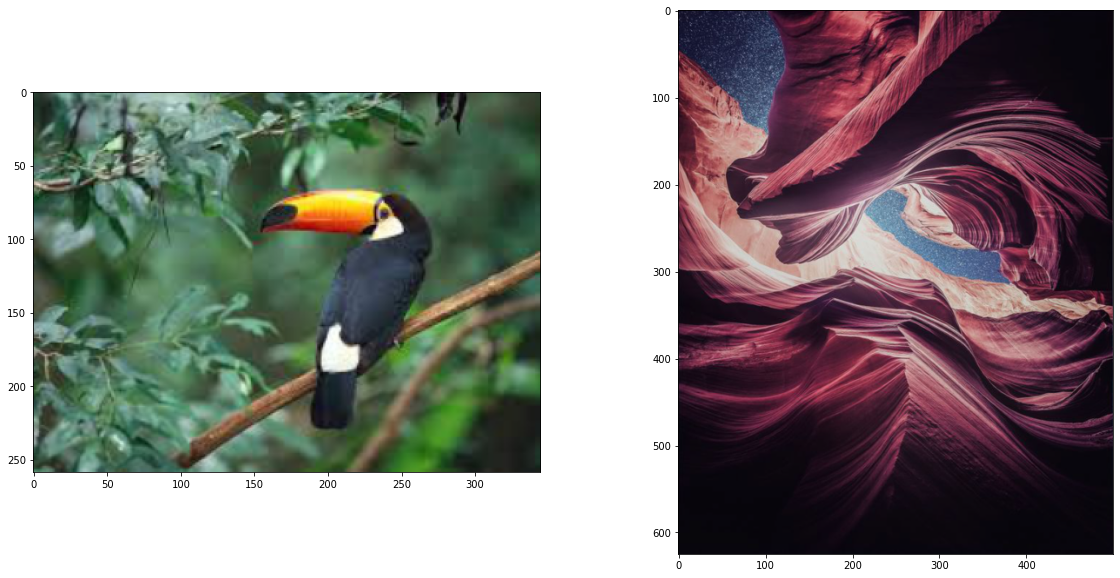

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
ax1.imshow(content_d)
ax2.imshow(style_d)

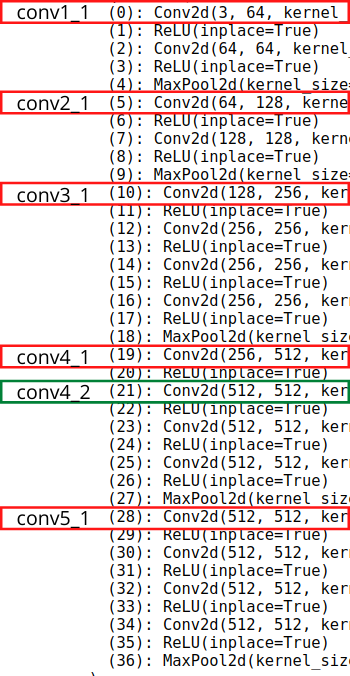

In [14]:
# Get content, style features and create gram matrix 

def get_features(image,model):

  layers = { 
      '0' : 'conv1_1',
      '5' : 'conv2_1',
      '10' : 'conv3_1',
      '19' : 'conv4_1',
      '21' : 'conv4_2', # content_feature
      '28' : 'conv5_1'

  }

  x  = image 
  
  Features = {}

  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      Features[layers[name]] = x

    return Features

In [15]:
content_f = get_features(content_p,vgg)
style_f = get_features(style_p,vgg)


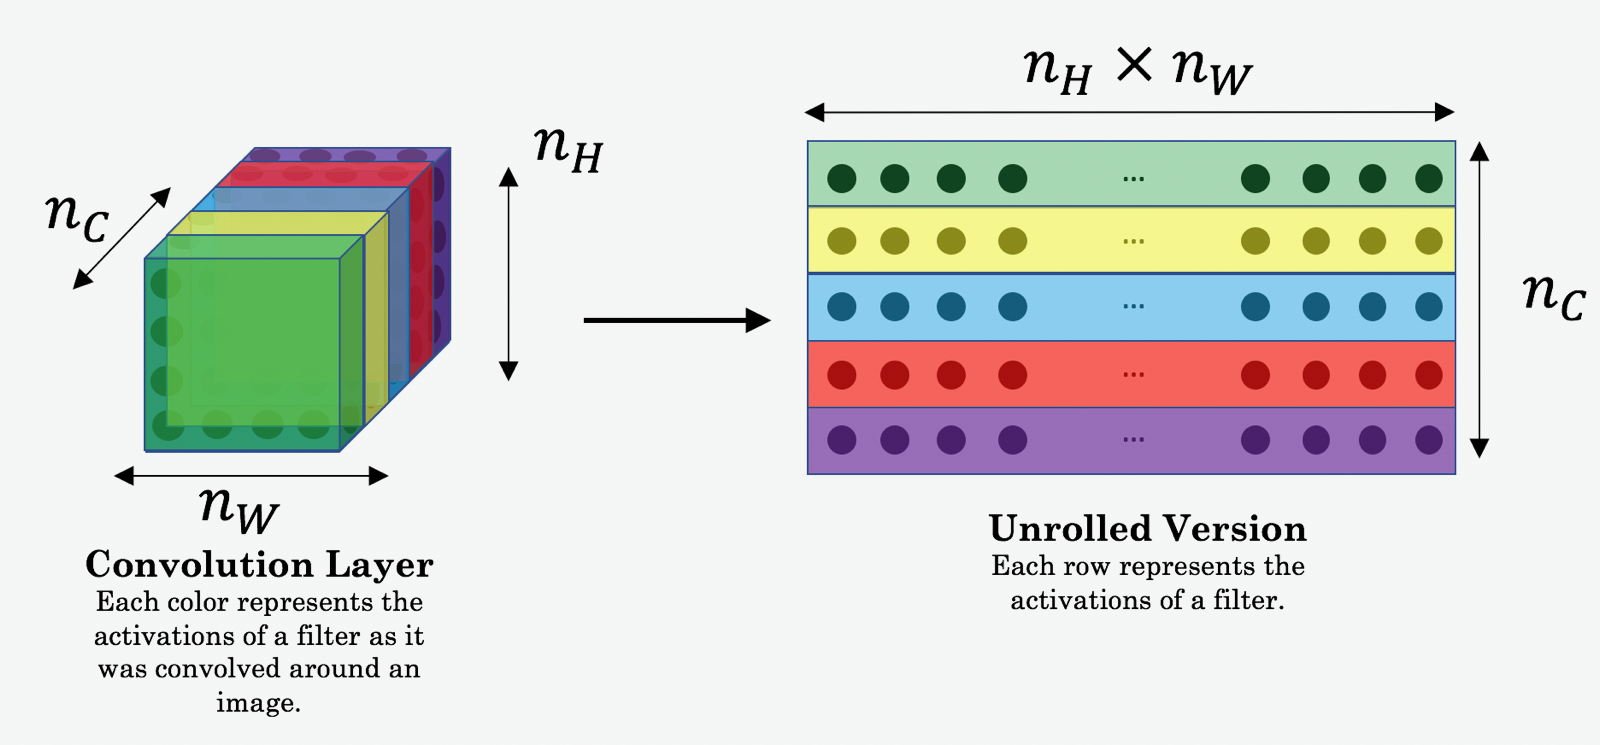



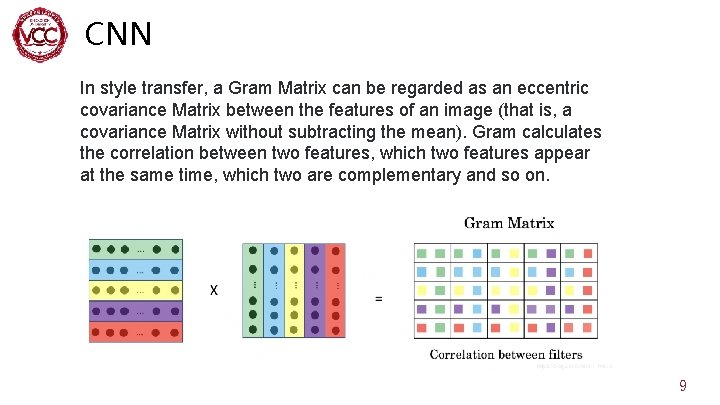

In [16]:
def gram_matrix(tensor):
  b,c,h,w = tensor.size()
  tensor = tensor.view(c,h*w)
  gram = torch.mm(tensor,tensor.t())
  return gram 

In [17]:
style_grams = {layer: gram_matrix(style_f[layer]) for layer in style_f}

In [18]:
# Creating Style and Content loss fucntion

def content_loss(target_conv4_2, content_conv4_2):
  loss = torch.mean((target_conv4_2-content_conv4_2)**2)
  return loss



In [19]:
style_weights = {
    'conv1_1' : 1.0,
    'conv2_1' : 0.75,
    'conv3_1' : 0.2,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2

}

In [20]:
def style_loss(style_weights,target_features,style_grams):
  loss = 0
  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_gram[layer]
    b,c,h,w = target_f.shape 
    layer_loss = style_weights[layers]*torch.mean((target_gram-style_gram)**2)
    loss += layer_loss/(c*h*w)
    return loss

In [21]:
target = content_p.clone().requires_grad_(True).to(device)
target_f = get_features(target,vgg)
print(target_f)


{'conv1_1': tensor([[[[-1.8150, -2.2055, -2.2628,  ..., -2.2002, -2.2056, -1.9436],
          [-1.7146, -2.0126, -2.0622,  ..., -2.0000, -2.0049, -1.8485],
          [-1.7352, -2.0327, -2.0724,  ..., -2.0021, -2.0049, -1.8485],
          ...,
          [-1.3738, -1.5075, -1.5474,  ..., -2.6078, -2.6062, -2.3485],
          [-0.8902, -0.8358, -0.8939,  ..., -2.6392, -2.6395, -2.3723],
          [-0.6522, -0.5324, -0.5897,  ..., -1.8694, -1.8697, -1.7294]],

         [[ 1.3344, -0.8825, -0.9372,  ..., -0.8944, -0.9278, -2.4695],
          [ 3.2672,  0.4197,  0.4224,  ...,  0.3278,  0.2849, -2.3440],
          [ 3.2931,  0.3801,  0.3924,  ...,  0.3182,  0.2849, -2.3440],
          ...,
          [ 3.3201,  1.3217,  1.5657,  ...,  0.3136,  0.3016, -3.5285],
          [ 3.0458,  1.8776,  2.0483,  ...,  0.3039,  0.3008, -3.5198],
          [ 1.4736,  1.1375,  1.4402,  ...,  3.3923,  3.3901,  0.1092]],

         [[-2.8348, -2.8556, -2.8978,  ..., -2.7328, -2.7336, -2.3913],
          [-3.2371

In [22]:
print("Content Loss : ",content_loss(target_f['conv4_2'],content_f['conv4_2']))
print("Style Loss : ",style_loss(style_weights, target_f , style_grams))

KeyError: ignored